In [46]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


In [47]:
ds_version = "V1_0"
annotations_file = "streetSurfaceVis_v1_0.csv"
# pred_file = "effnet_surface_quality_prediction-V1_0_s_1024-20240612_111928.csv"
root_data_path = os.path.join("..", "data", ds_version)
# root_data_path = f"/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/{ds_version}"
data_path = os.path.join(root_data_path, "metadata")
# only_validation = True

In [48]:
def compute_measures_cat(true, pred):
    return{
        "accuracy": sum(true == pred) / len(true)
    }

def compute_measures_float(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
    "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    "r_square": r2_score(true_float, pred_float),
    "mse": mean_squared_error(true_float, pred_float)
    }
    m["rmse"] = np.sqrt(m["mse"])
    return m

In [83]:
annot = pd.read_csv(os.path.join(root_data_path, annotations_file))
annot.rename(columns={"mapillary_image_id": "image_id", "surface_type": "type_true"}, inplace=True)
annot = annot[(annot.train == True)]

print(annot)

              image_id          user_id  user_name    captured_at  longitude  \
0     1000927687276860  103606985215406       dsmm  1655735677353  13.287805   
1     1001349260556407  102468835332129     ber319  1659015876793  14.426536   
2     1001419624308587  100232345559807  carlheinz  1698249177500  13.457938   
3     1001712924422413  100232345559807  carlheinz  1699107239000  13.386874   
4     1001853784055707  102627028648372  kartonage  1652268883000  13.389880   
...                ...              ...        ...            ...        ...   
8341   313341017115545  102518778654933    ankeric  1598541596000   6.175348   
8342   388685622320862  108444958057023     schulf  1568479945000   5.877558   
8343   466303284667808  102476798664422     ezinge  1612017944000   6.345509   
8344   495546874908270  103076698602835     mapnrw  1467907842360   7.266389   
8345   823532759145867  106761962414073     lena_r  1691150622018  10.217500   

       latitude  train      type_true s

In [88]:
df_blur_orig = pd.DataFrame(
    {"kernel": [0, 5, 5, 5, 7, 7, 7, 9, 9, 9, 11, 11, 11],
     "sigma": [0, 2, 3.5, 5, 2, 3.5, 5, 2, 3.5, 5, 2, 3.5, 5],
     "model_dataset": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    },
)

# df_blur = pd.DataFrame(
#     {"kernel": [0, 5, 7, 9, 11, 5, 7, 9, 11, 5, 7, 9, 11],
#      "sigma": [0, 2, 2, 2, 2, 3.5, 3.5, 3.5, 3.5, 5, 5, 5, 5],
#     },
# )

df_blur = pd.DataFrame(
    {"kernel": [0, 5, 5, 5, 7, 7, 7, 9, 9, 9, 11, 11, 11],
     "sigma": [0, 2, 3.5, 5, 2, 3.5, 5, 2, 3.5, 5, 2, 3.5, 5],
    },
)


gm_valid = np.zeros((df_blur.shape[0], df_blur.shape[0]))

gm_asphalt = np.zeros((df_blur.shape[0], df_blur.shape[0]))
gm_concrete = np.zeros((df_blur.shape[0], df_blur.shape[0]))
gm_paving_stones = np.zeros((df_blur.shape[0], df_blur.shape[0]))
gm_sett = np.zeros((df_blur.shape[0], df_blur.shape[0]))
gm_unpaved = np.zeros((df_blur.shape[0], df_blur.shape[0]))

cm_valid = np.zeros((df_blur.shape[0], df_blur.shape[0], 5, 5), dtype=int)

classification = pd.DataFrame()
classification["image_id"] = annot["image_id"]
classification["type_true"] = annot["type_true"]
classification.set_index("image_id", inplace=True)

yticklabels = []
xticklabels = []

for index_y, row_m in df_blur.iterrows():
    index_m = df_blur_orig[(df_blur_orig["kernel"]==row_m['kernel']) & (df_blur_orig["sigma"]==row_m['sigma'])]["model_dataset"].values[0]
    print(index_m)
    yticklabels.append(f"model_k_{row_m['kernel'] if row_m['kernel'] != 0 else None}_s_{row_m['sigma'] if row_m['sigma'] != 0 else None}")
    for index_x, row_d in df_blur.iterrows():
        index_d = df_blur_orig[(df_blur_orig["kernel"]==row_d['kernel']) & (df_blur_orig["sigma"]==row_d['sigma'])]["model_dataset"].values[0]
        print(index_d)
        if index_m == 0:
            xticklabels.append(f"dataset_k_{row_d['kernel'] if row_d['kernel'] != 0 else None}_s_{row_d['sigma'] if row_d['sigma'] != 0 else None}")
    
        # kernel = row_d["kernel"] if row_d["kernel"] != 0 else None
        # sigma = row_d["sigma"] if row_d["sigma"] != 0 else None
        name = f"effnet_blur_surface_pred_model{index_m}_dataset{index_d}-"
        pred_file = ""
        for root, _, fnames in sorted(os.walk(data_path, followlinks=False)):
            for fname in sorted(fnames):
                if name in fname and fname.endswith('.csv'):
                    pred_file = os.path.join(root, fname)
                    print(pred_file)
        if pred_file == "":
            raise ValueError(f"no prediction file found for model {index_m}, dataset {index_d}")
        
        pred = pd.DataFrame()

        print(f"reading {pred_file}")
        pred = pd.read_csv(pred_file)
        pred.rename(columns={"Image": "image_id",  "Level_0": "type_pred"}, inplace=True)

        type_pred = pred[pred.Level == "type"][["image_id", "Prediction", "type_pred", "is_in_validation"]]
        type_pred.rename(columns={"Prediction": "class_prob"}, inplace=True)
        idx = type_pred.groupby("image_id")["class_prob"].idxmax()
        type_pred = type_pred.loc[idx].reset_index()

        df = type_pred.set_index("image_id").join(annot[["image_id", "type_true"]].set_index("image_id"), how="left")
        df_valid_type = df[df.is_in_validation == 1]

        gm = compute_measures_cat(df_valid_type.type_true, df_valid_type.type_pred)
        gm_valid[index_y, index_x] = round(gm['accuracy'], 3)

        df_asphalt = df_valid_type[df_valid_type.type_true == "asphalt"]
        gm = compute_measures_cat(df_asphalt.type_true, df_asphalt.type_pred)
        gm_asphalt[index_y, index_x] = round(gm['accuracy'], 3)

        df_concrete = df_valid_type[df_valid_type.type_true == "concrete"]
        gm = compute_measures_cat(df_concrete.type_true, df_concrete.type_pred)
        gm_concrete[index_y, index_x] = round(gm['accuracy'], 3)

        df_paving_stones = df_valid_type[df_valid_type.type_true == "paving_stones"]
        gm = compute_measures_cat(df_paving_stones.type_true, df_paving_stones.type_pred)
        gm_paving_stones[index_y, index_x] = round(gm['accuracy'], 3)

        df_sett = df_valid_type[df_valid_type.type_true == "sett"]
        gm = compute_measures_cat(df_sett.type_true, df_sett.type_pred)
        gm_sett[index_y, index_x] = round(gm['accuracy'], 3)

        df_unpaved = df_valid_type[df_valid_type.type_true == "unpaved"]
        gm = compute_measures_cat(df_unpaved.type_true, df_unpaved.type_pred)
        gm_unpaved[index_y, index_x] = round(gm['accuracy'], 3)

        cm = confusion_matrix(df_valid_type.type_true, df_valid_type.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
        cm_valid[index_y, index_x, :, :] = cm

        # misclassification
        if (index_m == 0) & (index_d == 0):
            classification = classification.join(type_pred[["image_id", "is_in_validation"]].set_index("image_id"), how="left")

        column = f"model_k_{row_m['kernel'] if row_m['kernel'] != 0 else None}_s_{row_m['sigma'] if row_m['sigma'] != 0 else None}_dataset_k_{row_d['kernel'] if row_d['kernel'] != 0 else None}_s_{row_d['sigma'] if row_d['sigma'] != 0 else None}"
        type_pred.rename(columns={"type_pred": column}, inplace=True)
        classification = classification.join(type_pred[["image_id", column]].set_index("image_id"), how="left")
classification.to_csv(os.path.join(data_path, "model_predictions", "classification_blur.csv"), index=True)


0
0
../data/V1_0/metadata/effnet_blur_surface_pred_model0_dataset0-V1_0_annotated-20240627_230629.csv
reading ../data/V1_0/metadata/effnet_blur_surface_pred_model0_dataset0-V1_0_annotated-20240627_230629.csv
1
../data/V1_0/metadata/effnet_blur_surface_pred_model0_dataset1-V1_0_annotated-20240627_231013.csv
reading ../data/V1_0/metadata/effnet_blur_surface_pred_model0_dataset1-V1_0_annotated-20240627_231013.csv
2
../data/V1_0/metadata/effnet_blur_surface_pred_model0_dataset2-V1_0_annotated-20240627_231358.csv
reading ../data/V1_0/metadata/effnet_blur_surface_pred_model0_dataset2-V1_0_annotated-20240627_231358.csv
3
../data/V1_0/metadata/effnet_blur_surface_pred_model0_dataset3-V1_0_annotated-20240627_231742.csv
reading ../data/V1_0/metadata/effnet_blur_surface_pred_model0_dataset3-V1_0_annotated-20240627_231742.csv
4
../data/V1_0/metadata/effnet_blur_surface_pred_model0_dataset4-V1_0_annotated-20240627_232126.csv
reading ../data/V1_0/metadata/effnet_blur_surface_pred_model0_dataset4-V1_

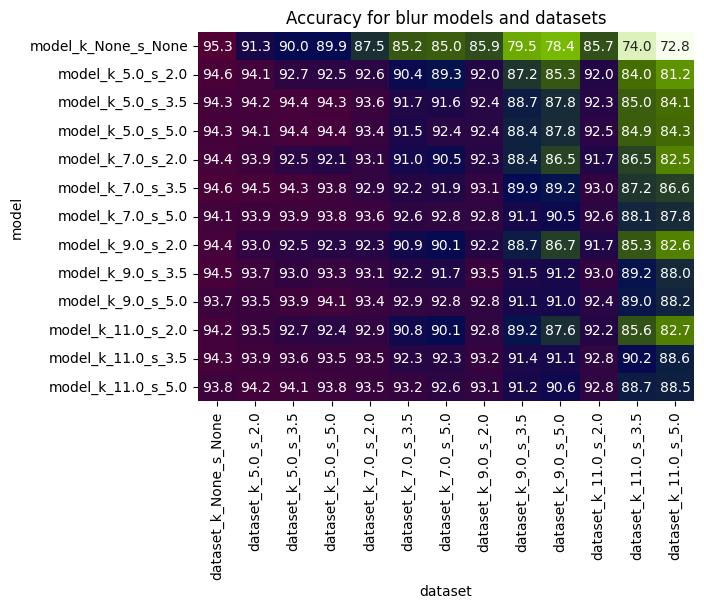

In [51]:
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#456D00", "#000B53", "#530035"])

plt.figure()
sns.heatmap(gm_valid*100, annot=True, fmt=".1f", cmap=cmap, cbar=False,
            xticklabels=xticklabels,
            yticklabels=yticklabels)
plt.title(f"Accuracy for blur models and datasets")
plt.xlabel("dataset")
plt.ylabel("model")
# plt.savefig("blur_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

# Blur dataset per type

### Asphalt

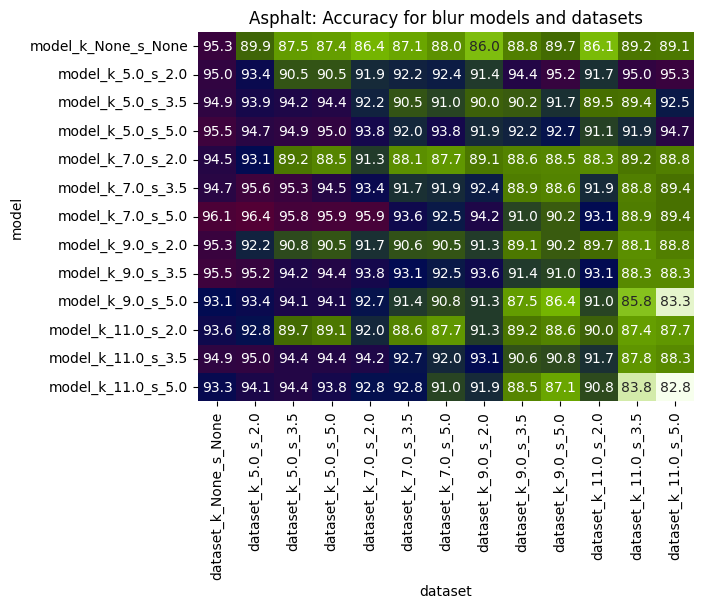

In [89]:
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#456D00", "#000B53", "#530035"])

plt.figure()
sns.heatmap(gm_asphalt*100, annot=True, fmt=".1f", cmap=cmap, cbar=False,
            xticklabels=xticklabels,
            yticklabels=yticklabels)
plt.title(f"Asphalt: Accuracy for blur models and datasets")
plt.xlabel("dataset")
plt.ylabel("model")
# plt.savefig("blur_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

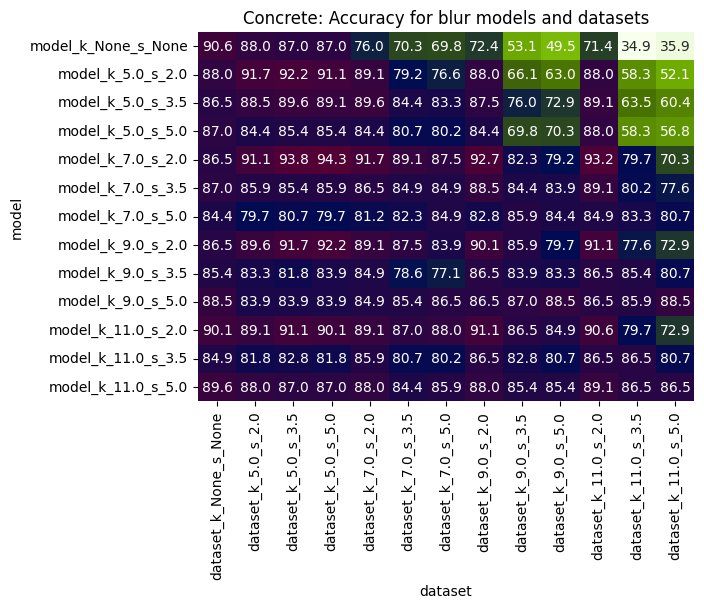

In [56]:
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#456D00", "#000B53", "#530035"])

plt.figure()
sns.heatmap(gm_concrete*100, annot=True, fmt=".1f", cmap=cmap, cbar=False,
            xticklabels=xticklabels,
            yticklabels=yticklabels)
plt.title(f"Concrete: Accuracy for blur models and datasets")
plt.xlabel("dataset")
plt.ylabel("model")
# plt.savefig("blur_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

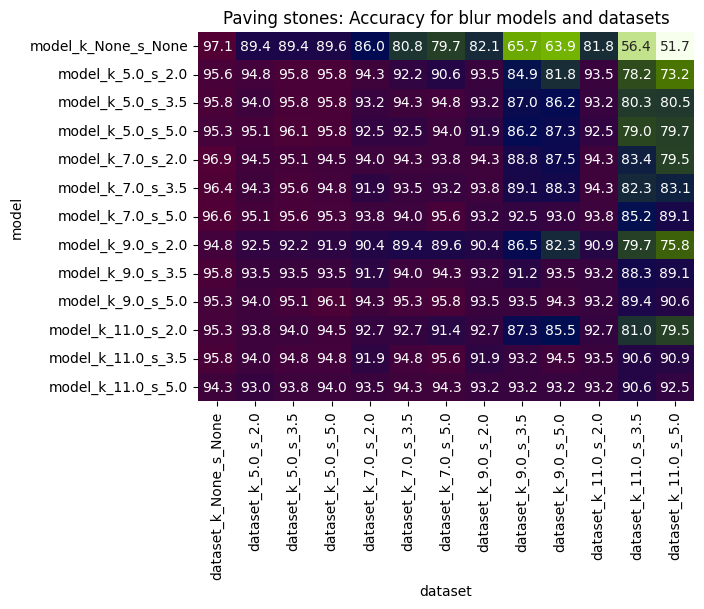

In [57]:
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#456D00", "#000B53", "#530035"])

plt.figure()
sns.heatmap(gm_paving_stones*100, annot=True, fmt=".1f", cmap=cmap, cbar=False,
            xticklabels=xticklabels,
            yticklabels=yticklabels)
plt.title(f"Paving stones: Accuracy for blur models and datasets")
plt.xlabel("dataset")
plt.ylabel("model")
# plt.savefig("blur_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

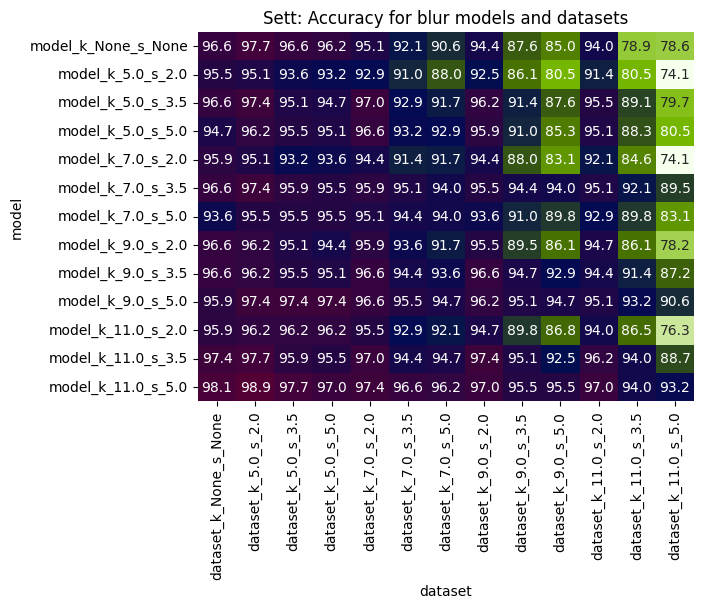

In [58]:
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#456D00", "#000B53", "#530035"])

plt.figure()
sns.heatmap(gm_sett*100, annot=True, fmt=".1f", cmap=cmap, cbar=False,
            xticklabels=xticklabels,
            yticklabels=yticklabels)
plt.title(f"Sett: Accuracy for blur models and datasets")
plt.xlabel("dataset")
plt.ylabel("model")
# plt.savefig("blur_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

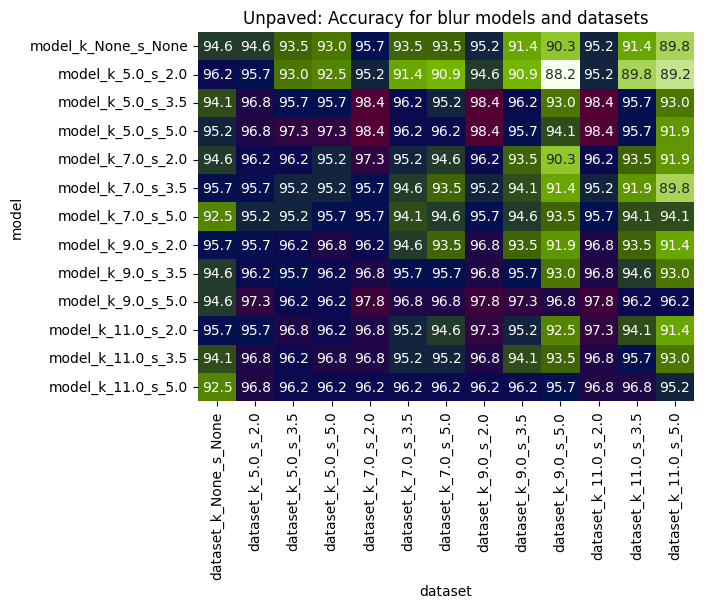

In [59]:
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#456D00", "#000B53", "#530035"])

plt.figure()
sns.heatmap(gm_unpaved*100, annot=True, fmt=".1f", cmap=cmap, cbar=False,
            xticklabels=xticklabels,
            yticklabels=yticklabels)
plt.title(f"Unpaved: Accuracy for blur models and datasets")
plt.xlabel("dataset")
plt.ylabel("model")
# plt.savefig("blur_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

# Confusion Matrix

In [61]:
def plot_conf_matrix(cm, model, dataset):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
                yticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
    plt.title(f"Confusion Matrix for model {model} and dataset {dataset}")
    plt.xlabel("Predicted")
    plt.ylabel("Annotated")
    plt.show()

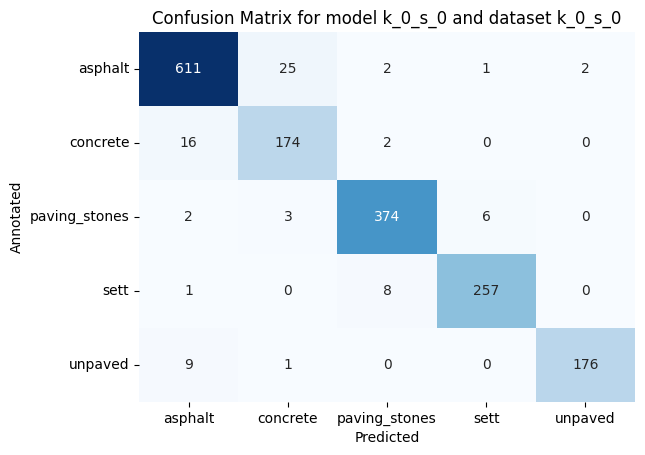

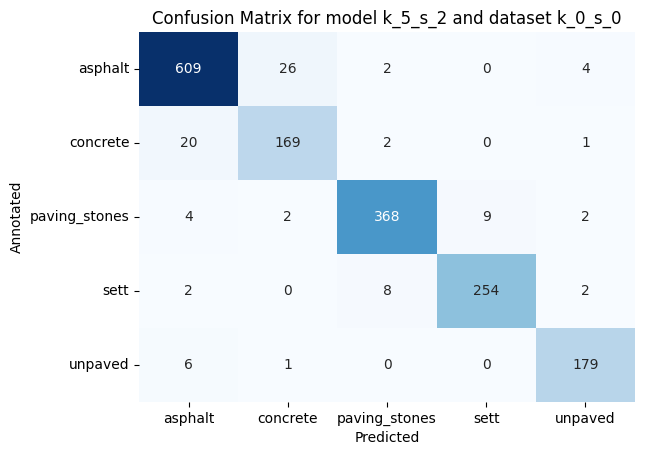

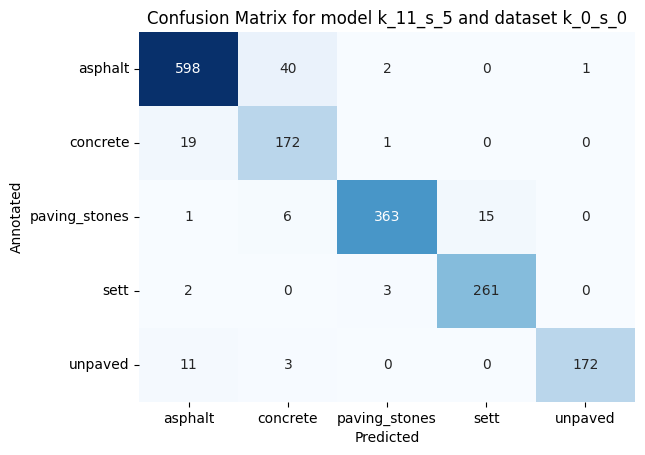

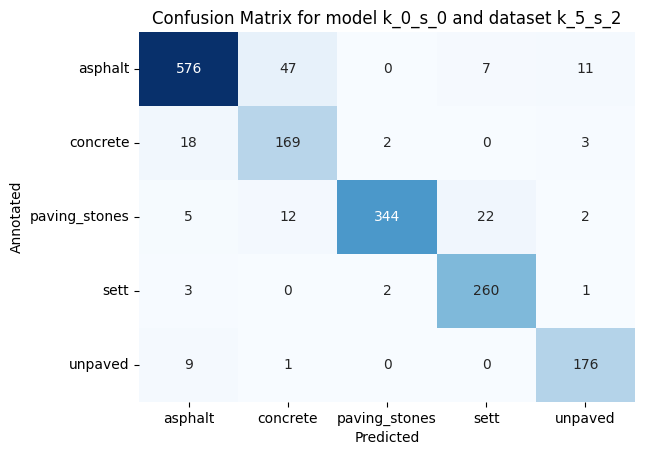

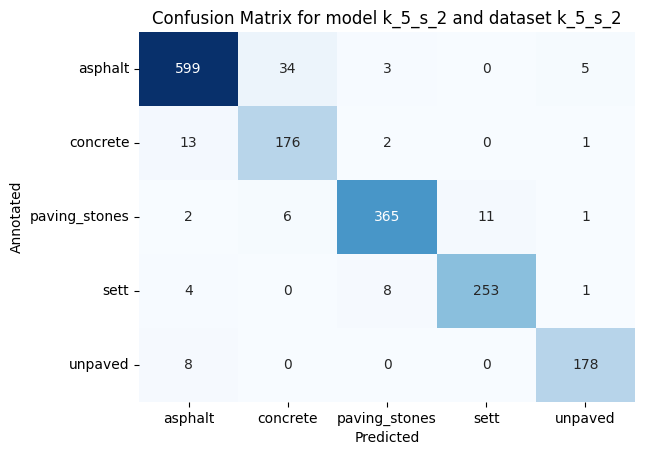

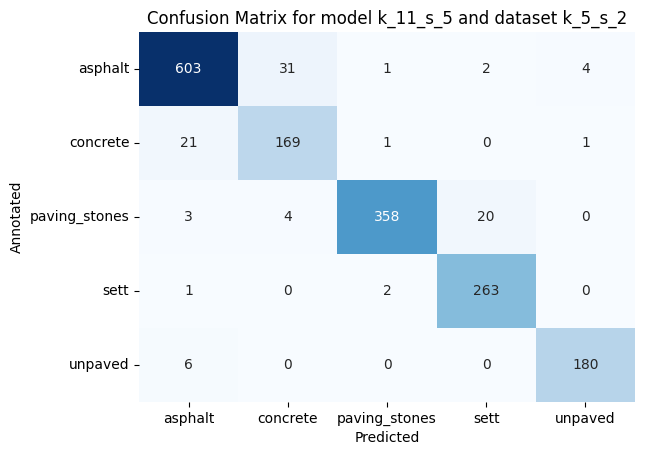

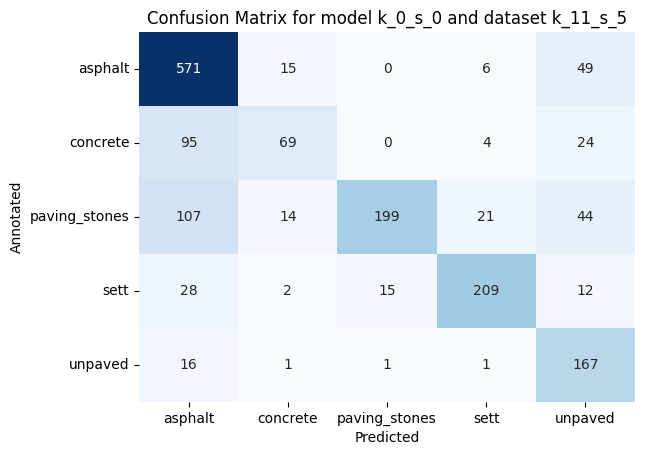

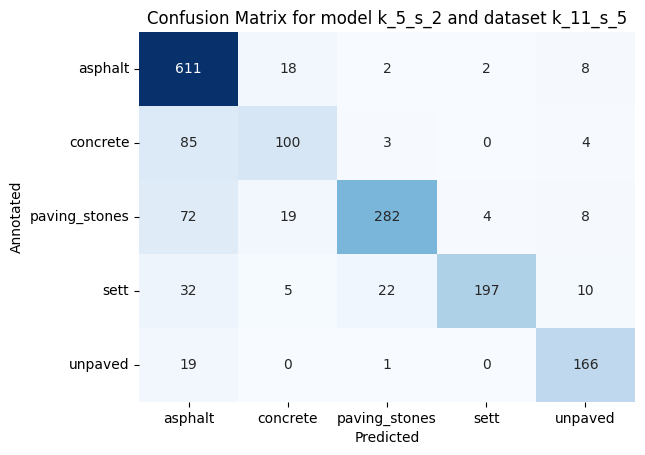

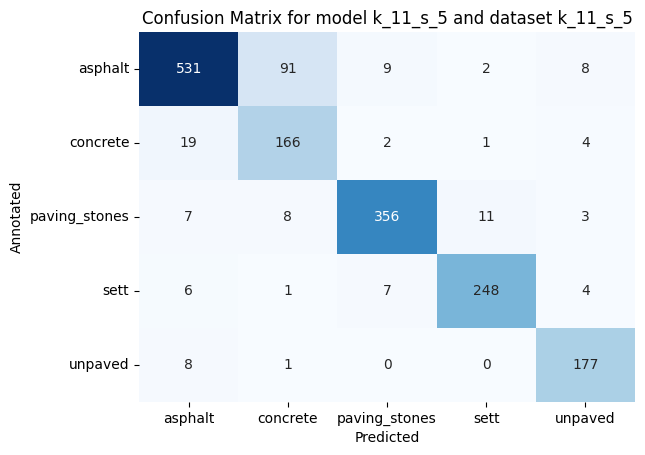

In [90]:
# k_5 s_2 & k_11 s_5

selected_models = pd.DataFrame(
    {"kernel": [0, 5, 11],
     "sigma": [0, 2, 5],
    },
)

selected_datasets = pd.DataFrame(
    {"kernel": [0, 5, 11],
     "sigma": [0, 2, 5],
    },
)

for _, data_row in selected_datasets.iterrows():
    for _, model_row in selected_models.iterrows():

        index_y = df_blur.index[(df_blur["kernel"]==model_row["kernel"]) & (df_blur_orig["sigma"]==model_row["sigma"])][0]
        index_x = df_blur.index[(df_blur["kernel"]==data_row["kernel"]) & (df_blur_orig["sigma"]==data_row["sigma"])][0]

        plot_conf_matrix(cm_valid[index_y, index_x, :, :], f"k_{model_row['kernel']}_s_{model_row['sigma']}", f"k_{data_row['kernel']}_s_{data_row['sigma']}")

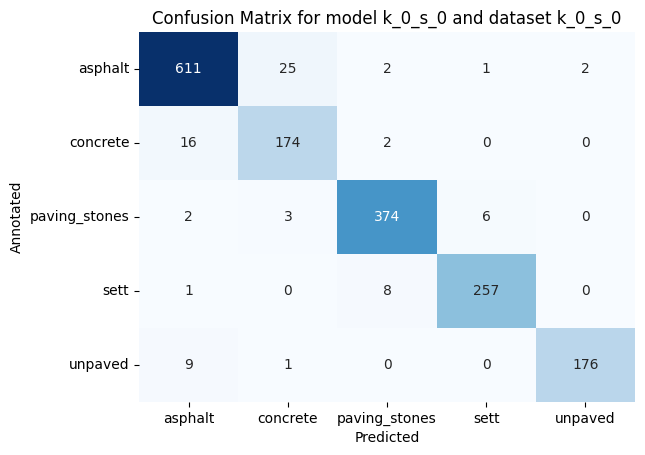

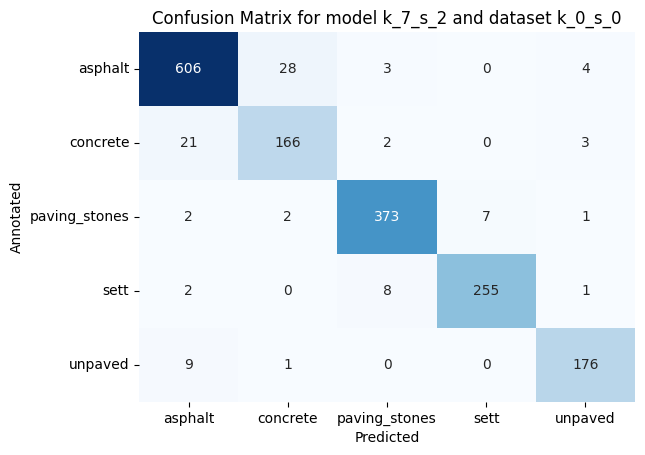

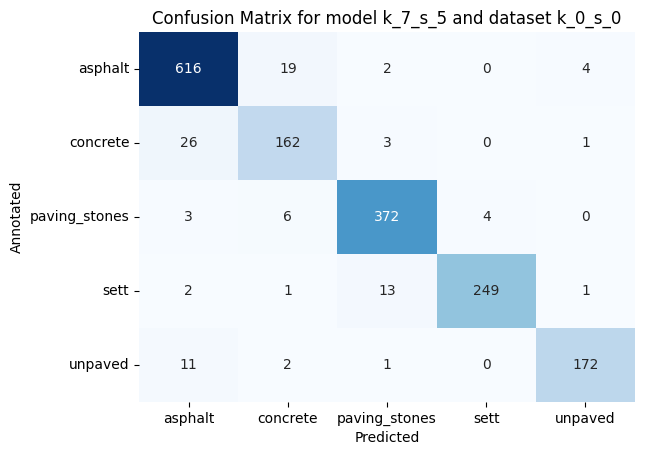

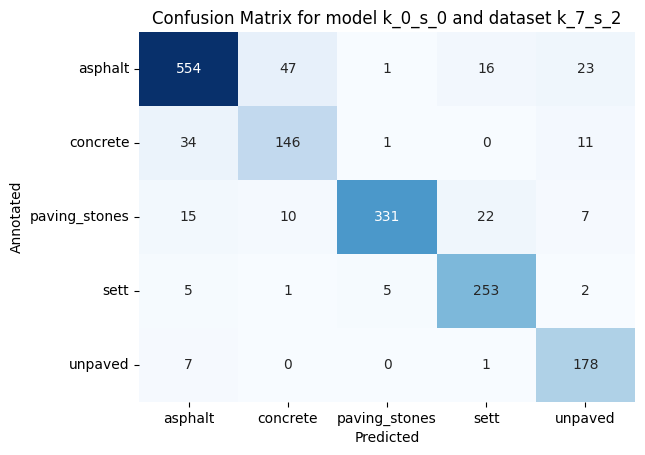

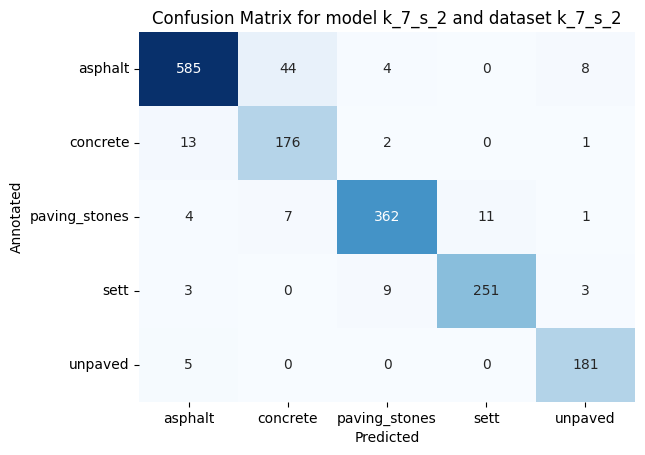

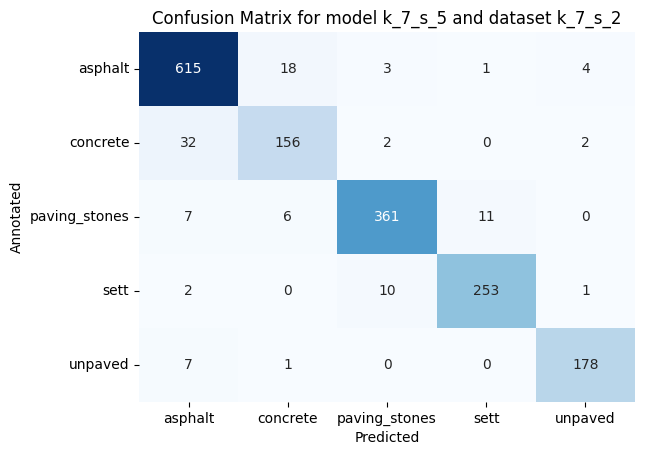

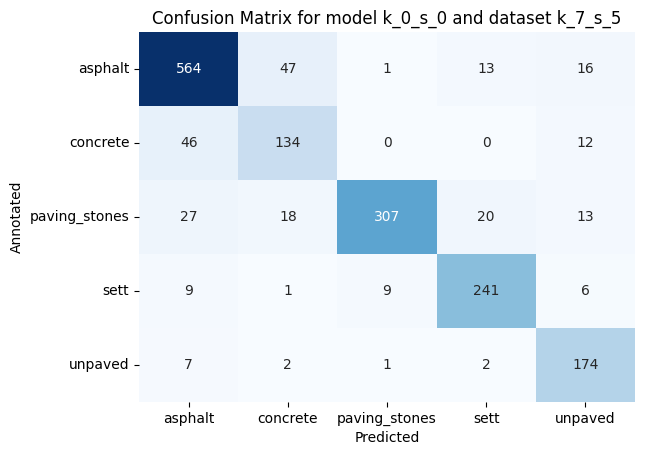

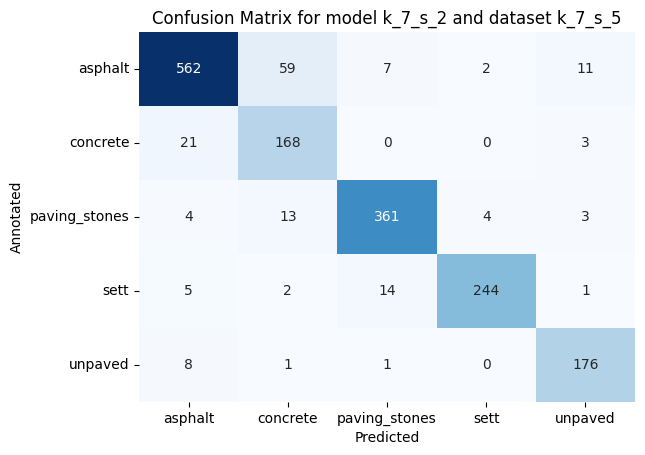

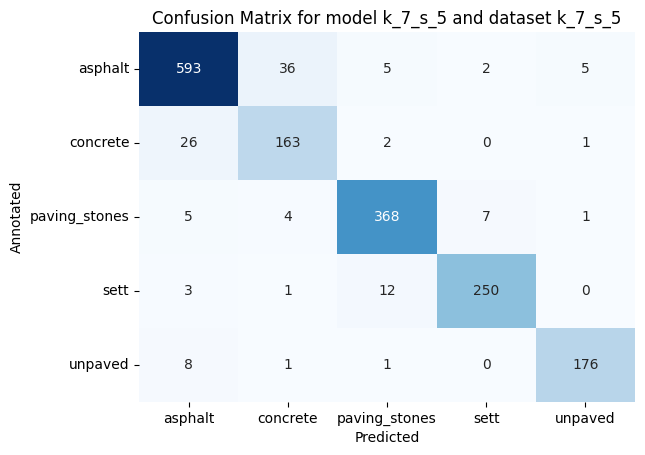

In [77]:
# k_7 s_2 & k_7 s_5

selected_models = pd.DataFrame(
    {"kernel": [0, 7, 7],
     "sigma": [0, 2, 5],
    },
)

selected_datasets = pd.DataFrame(
    {"kernel": [0, 7, 7],
     "sigma": [0, 2, 5],
    },
)

for _, data_row in selected_datasets.iterrows():
    for _, model_row in selected_models.iterrows():

        index_y = df_blur.index[(df_blur["kernel"]==model_row["kernel"]) & (df_blur_orig["sigma"]==model_row["sigma"])][0]
        index_x = df_blur.index[(df_blur["kernel"]==data_row["kernel"]) & (df_blur_orig["sigma"]==data_row["sigma"])][0]

        plot_conf_matrix(cm_valid[index_y, index_x, :, :], f"k_{model_row['kernel']}_s_{model_row['sigma']}", f"k_{data_row['kernel']}_s_{data_row['sigma']}")

# Misclassified

In [ ]:
# # all images that were incorrectly classified
# misclassification = df[(df.surface_label_pred != df.surface_true) & (df.is_in_validation == 1)]

# misclassification = misclassification.sort_values("image_id")
# misclassification.reset_index( inplace=True)
# misclassification[["image_id", "is_in_validation", 
#                    "surface_true", "surface_label_pred", "quality_label_true"]
#                    ].to_csv(os.path.join(data_path, "model_predictions", "misclassification_surface.csv"), index=False)